In [166]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

##Import any other packages you may need here
from skimage.io import imread,imshow
import scipy

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_df.columns = ["Image", "Findings", "Followup", "PatientID", "Age", "Gender","ViewPosition", "OriginalImageWidth",
       "OriginalImageHeight", "OriginalImagePixelSpacingX", "OriginalImagePixelSpacingY", "Unnamed: 11"]
all_df.head(3)

,Image,Findings,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.columns = ["Image", "Findings", "Followup", "PatientID", "Age", "Gender","ViewPosition", "OriginalImageWidth",
       "OriginalImageHeight", "OriginalImagePixelSpacingX", "OriginalImagePixelSpacingY"]
sample_df.head(3)

,Image,Findings,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168


In [5]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Image                       112120 non-null  object 
 1   Findings                    112120 non-null  object 
 2   Followup                    112120 non-null  int64  
 3   PatientID                   112120 non-null  int64  
 4   Age                         112120 non-null  int64  
 5   Gender                      112120 non-null  object 
 6   ViewPosition                112120 non-null  object 
 7   OriginalImageWidth          112120 non-null  int64  
 8   OriginalImageHeight         112120 non-null  int64  
 9   OriginalImagePixelSpacingX  112120 non-null  float64
 10  OriginalImagePixelSpacingY  112120 non-null  float64
 11  Unnamed: 11                 0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


### Exploring the number of rows

In [6]:
## EDA
# Todo 
# 1. Count rows in both full and sample data
# 2. One-hot encoding of labels
# 2. total disease labels
# 3. disease prevalence (%ages and charts)
# 4. Co-occurence of diseases

### Counting number of rows in both datasets

In [7]:
len(all_df)

112120

In [8]:
len(sample_df)

5606

There are more rows in **all_df** than the **sample_df** as expected

## Processing the data for analysis -- adding columns for each disease label

In [9]:
labels = np.unique(list(chain(*all_df['Findings'].map(lambda x: x.split('|'))))) 
labels = [lbl for lbl in labels if len(lbl)>1]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [10]:
len(labels)

15

In [11]:
for lbl in labels:
    all_df[lbl] = all_df['Findings'].map(lambda x: 1.0 if lbl in x else 0)
    
pd.options.display.max_columns = None
all_df.head(3)

,Image,Findings,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploring disease frequencies

[Text(0, 0.5, 'Total cases in the dataset')]

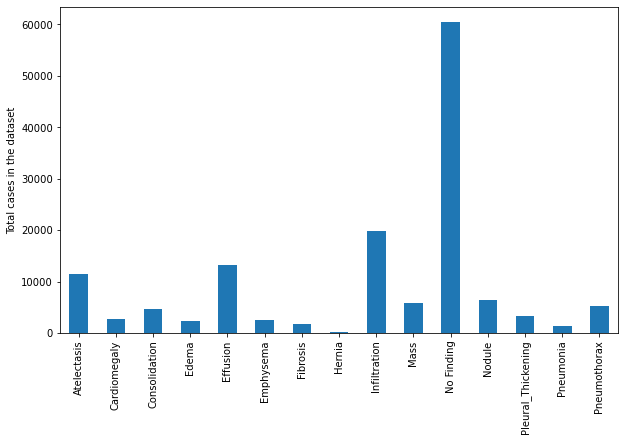

In [12]:
plt.figure(figsize=(10,6))
ax = all_df[labels].sum().plot(kind='bar')
ax.set(ylabel='Total cases in the dataset')

In [13]:
all_df[labels].sum()/len(all_df[all_df.Findings!='null'])*100

Atelectasis           10.309490
Cardiomegaly           2.475919
Consolidation          4.162504
Edema                  2.054049
Effusion              11.877453
Emphysema              2.244024
Fibrosis               1.503746
Hernia                 0.202462
Infiltration          17.743489
Mass                   5.156975
No Finding            53.836068
Nodule                 5.646629
Pleural_Thickening     3.019087
Pneumonia              1.276311
Pneumothorax           4.728862
dtype: float64

#### 53% of these recorded rows have no disease at all. Pneumonia comprise 1.28% of the all diseases in the dataset.

### Exploring co-morbidities for the disease of interest i.e. Pneumothorax

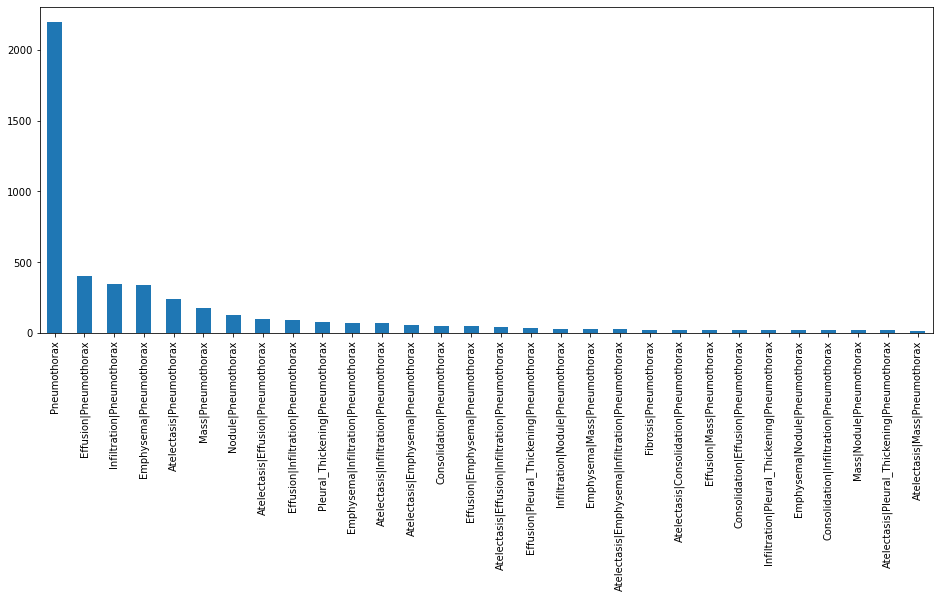

In [14]:
plt.figure(figsize=(16,6))
all_df[all_df.Pneumothorax==1]['Findings'].value_counts()[0:30].plot(kind='bar')

The above graph displays common co-morbidities of Pneumonia. It can be seeen that Effusion, Infiltration, Emphysema, Atelectasis and Mass are top-5 co-morbidities of Pneumonia.

### Analysing disease prevalence by age across the dataset

In [15]:
min_age, max_age, avg_age = np.min(all_df['Age']), np.max(all_df['Age']), np.mean(all_df['Age'])
min_age, max_age, np.int64(avg_age)

(1, 414, 46)

### Checking patients where age is over 100

In [16]:
all_df[all_df.Age>100]

,Image,Findings,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Fixing these records by assigning them the average age across the whole dataset

In [17]:
all_df['Age'] = all_df['Age'].map(lambda age: np.int64(avg_age) if age > 100 else age)

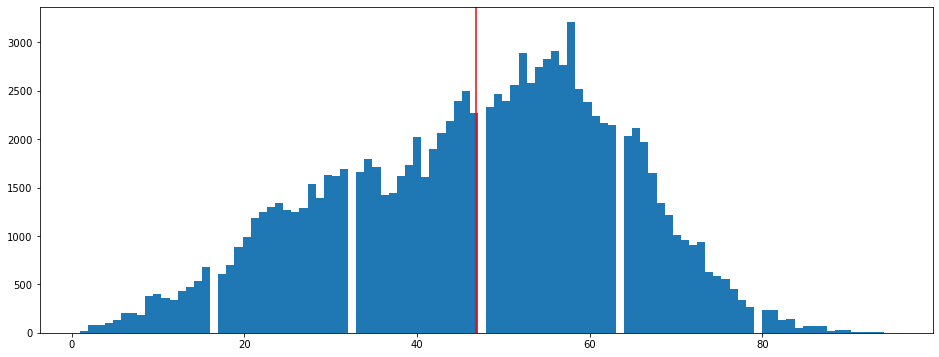

In [18]:
plt.figure(figsize=(16,6))
plt.hist(all_df['Age'].ravel(), bins=100)
plt.axvline(np.mean(all_df['Age']), color = "red")

### Analysing disease prevalence by age across the Pneumothorax patients

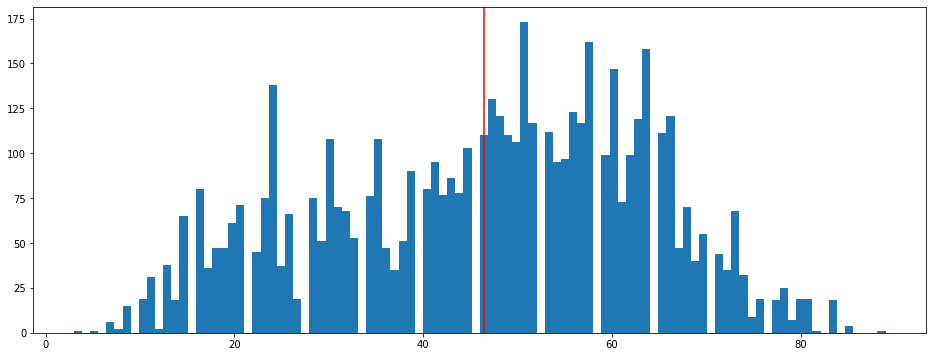

In [19]:
plt.figure(figsize=(16,6))
plt.hist(all_df[all_df.Pneumothorax==1]['Age'].ravel(), bins=100)
plt.axvline(np.mean(all_df[all_df.Pneumothorax==1]['Age']), color = "red")

### Analysing disease prevalence by Gender across the dataset


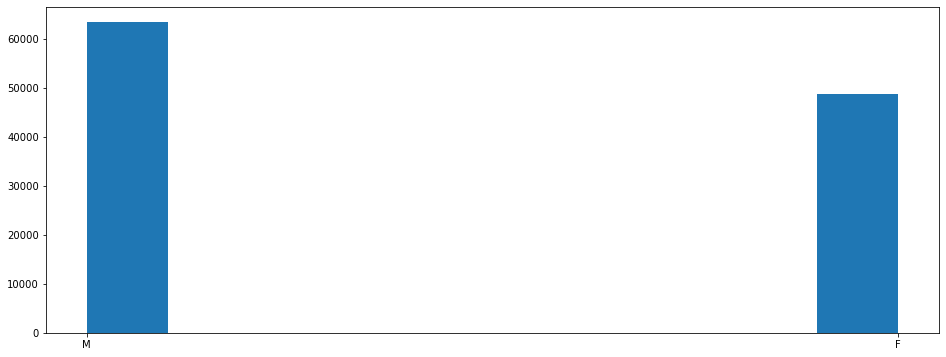

In [20]:
plt.figure(figsize=(16,6))
plt.hist(all_df['Gender']);

In [21]:
all_df['Gender'].value_counts()/len(all_df) * 100

M    56.493043
F    43.506957
Name: Gender, dtype: float64

There are more men in the dataset than women,  generally.

In [167]:
scipy.stats.ttest_ind(all_df['Age'][all_df['Gender']=='M'],
                      all_df['Age'][all_df['Gender']=='F'],nan_policy='omit')

Ttest_indResult(statistic=6.471603825136853, pvalue=9.736600295987243e-11)

T-test reveals a significant statistical difference exists betweeen the ages of male and female patients.

### Analysing disease prevalence by Gender across the Pneumothorax patients


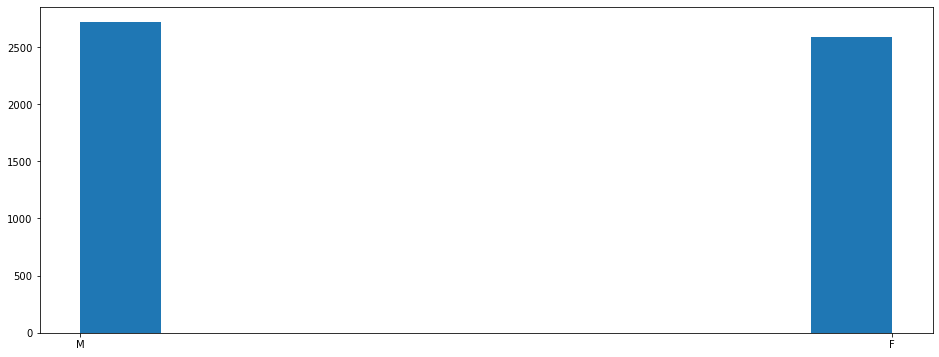

In [22]:
plt.figure(figsize=(16,6))
plt.hist(all_df[all_df.Pneumothorax==1]['Gender']);

### Average diseases per patient

In [23]:
np.mean(all_df[labels].sum(axis=1))

1.2623706742775598

Exclusing the No Findings ones

In [24]:
np.mean(all_df[set(labels) - set(['No Finding'])].sum(axis=1))

0.7240099892971816

### Unique patients in the dataset

In [25]:
print('There are {} unique patients in the dataset.'.format(len(all_df['PatientID'].unique())))

There are 30805 unique patients in the dataset.


### Distribution by view position

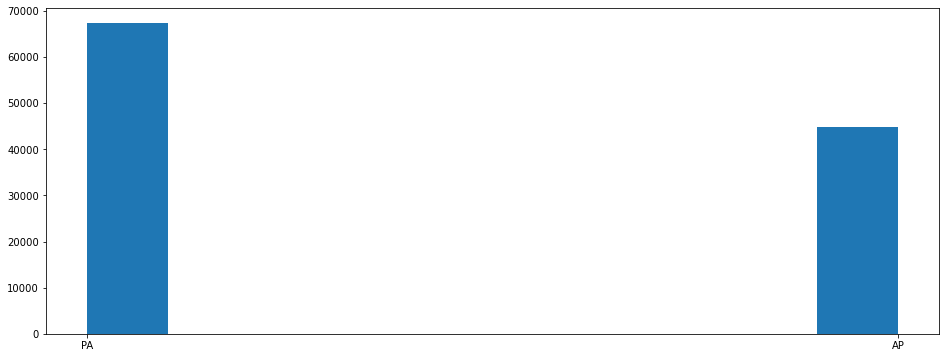

In [26]:
plt.figure(figsize=(16,6))
plt.hist(all_df['ViewPosition']);

In [27]:
all_df['ViewPosition'].value_counts()/len(all_df) * 100

PA    60.033892
AP    39.966108
Name: ViewPosition, dtype: float64

The ration of PA to AP is 60:40. This needs to be preserved during the training phase.

## Pixel Level Assessments

In [34]:
for lbl in labels:
    sample_df[lbl] = sample_df['Findings'].map(lambda x: 1.0 if lbl in x else 0)
    
sample_df.head(3)

,Image,Findings,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,FilePath,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
all_image_files = {os.path.basename(x): x for x in glob('/data/images_*/images/*.png')}

In [29]:
sample_df['FilePath'] = sample_df['Image'].map(lambda f: all_image_files.get(f))

In [54]:
pd.set_option('display.max_rows', None)
sample_df.head(5)

,Image,Findings,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,FilePath,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_001.png,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Grabing the first record for each disease to explore images and intensity distribution

In [109]:
filtered_sample_df = sample_df.groupby("Findings").first().reset_index()

filtered_sample_df.head(3)

,Findings,Image,Followup,PatientID,Age,Gender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,OriginalImagePixelSpacingY,FilePath,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,Atelectasis,00000030_001.png,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Atelectasis|Cardiomegaly,00008716_000.png,0,8716,033Y,F,PA,2500,2048,0.168,0.168,/data/images_004/images/00008716_000.png,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Atelectasis|Cardiomegaly|Consolidation,00020349_011.png,11,20349,018Y,F,PA,2406,2593,0.143,0.143,/data/images_009/images/00020349_011.png,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Displaying X-rays for Pneumonia and its Co-morbidities

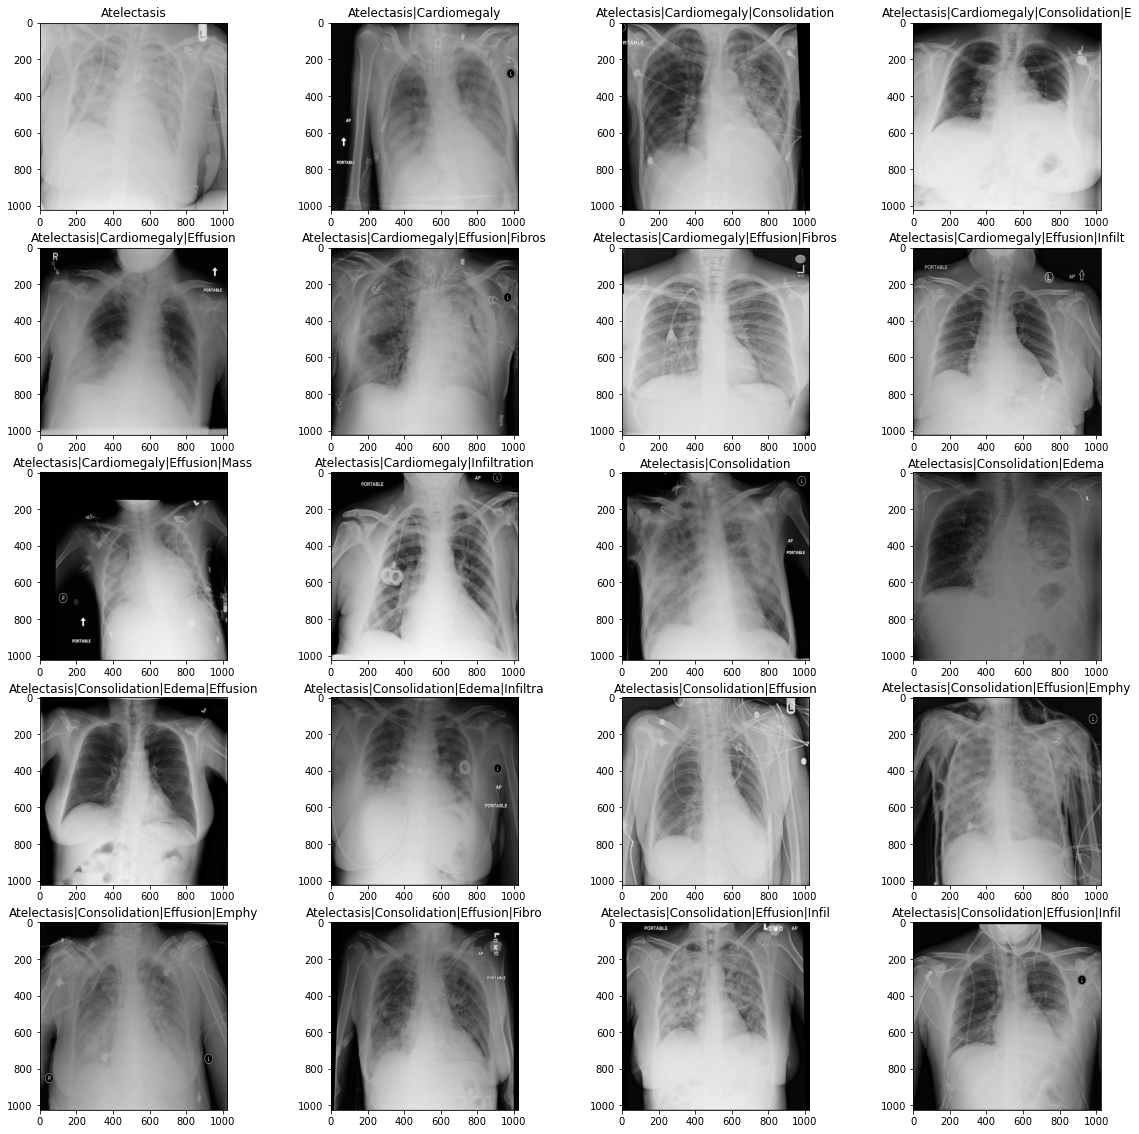

In [162]:
fig, plots=plt.subplots(5,4,figsize=(20,20))
plots=plots.flatten()
for i, v in enumerate(filtered_sample_df[filtered_sample_df.Pneumonia==1][:20]["FilePath"].values):
    img = imread(v)
    plots[i].imshow(img, cmap="gray")
    plots[i].set_title(filtered_sample_df["Findings"].values[i][0:40])


#### Displaying the intensity distribution of X-rays for Pneumonia and its Co-morbidities

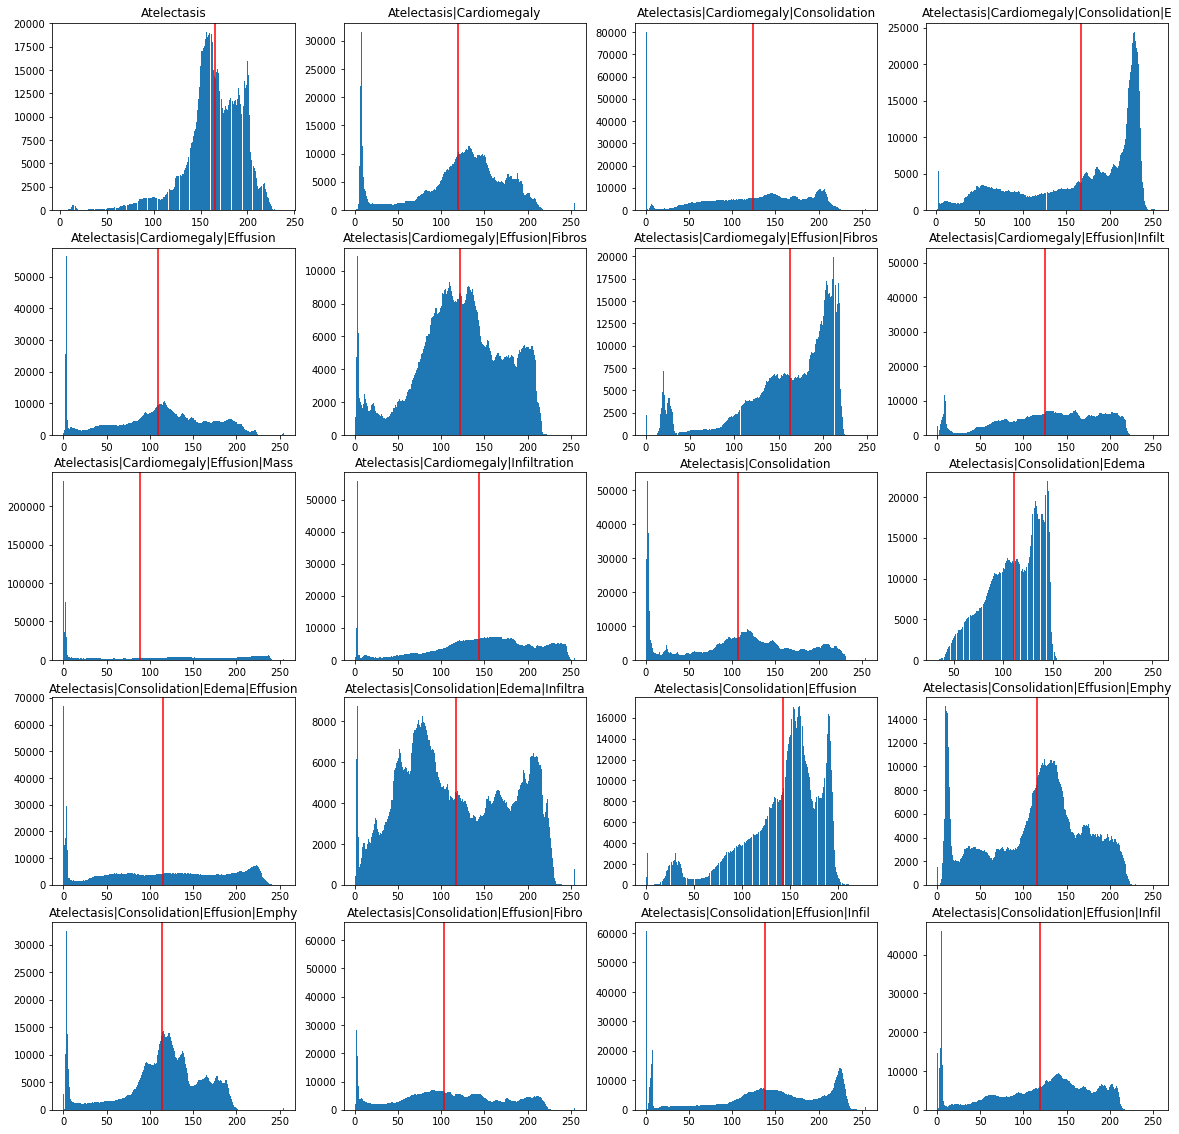

In [160]:
fig, plots=plt.subplots(5,4,figsize=(20,20))
plots=plots.flatten()
for i, v in enumerate(filtered_sample_df[filtered_sample_df.Pneumonia==1][:20]["FilePath"].values):
    img = imread(v)
    plots[i].hist(img.ravel(), bins=256)
    plots[i].axvline(np.mean(img), color="red")
    plots[i].set_title(filtered_sample_df["Findings"].values[i][0:40])
    
    

#### Displaying the normalized intensity distribution of X-rays for Pneumonia and its Co-morbidities

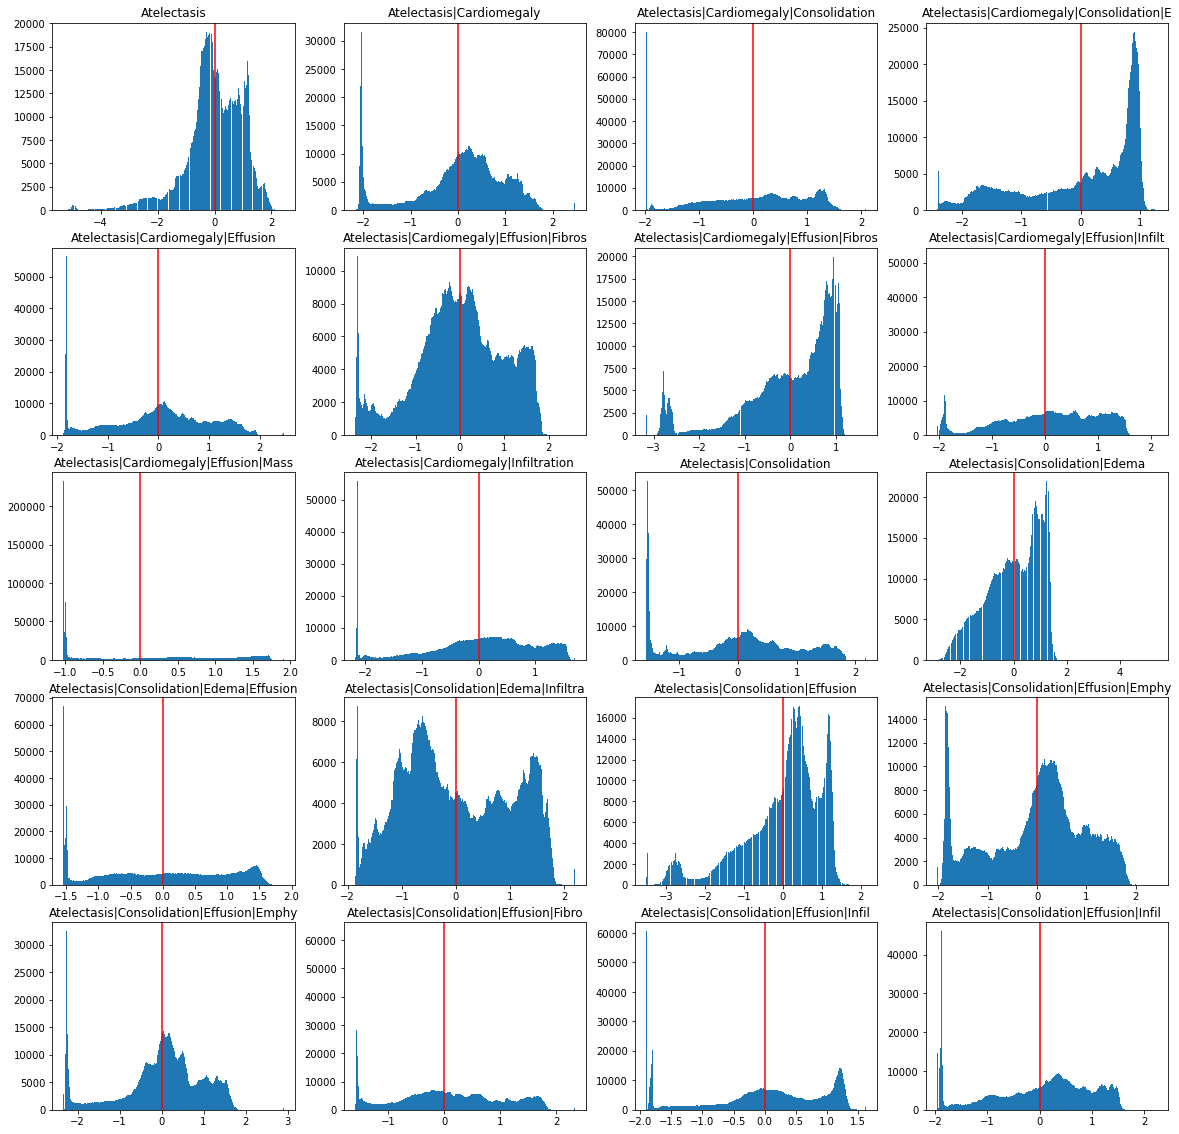

In [163]:
fig, plots=plt.subplots(5,4,figsize=(20,20))
plots=plots.flatten()
for i, v in enumerate(filtered_sample_df[filtered_sample_df.Pneumonia==1][:20]["FilePath"].values):
    img = imread(v)
    mean, std = np.mean(img), np.std(img)
    img_norm = (img - mean) / std
    plots[i].hist(img_norm.ravel(), bins=256)
    plots[i].axvline(np.mean(img_norm), color="red")
    plots[i].set_title(filtered_sample_df["Findings"].values[i][0:40])
    

The normalized distribution shows that both x and y axes values vary sgnificantly across the x-rays with Pneumonia and other co-morbidities. The inensity peaks and distribution shapes are very different as well. Deep learning algorithm shall be able to learn these nuances to classify x-rays correctly.